<b>Problem Explained</b>

While GPS works fairly reliably outdoors, it's a problem when it comes to locationing indoors where generaly either doesn't work or it's not so accurate. However, there are other techniques that can be explored. On the following line we will investigate the feasibility of using "wifi fingerprinting" to determine a person's location in indoor spaces. 
Wifi fingerprinting uses the signals from multiple wifi hotspots within the building to determine location, analogously to how GPS uses satellite signals.

We have been provided with a large database of wifi fingerprints for a multi-building industrial campus with a location (building, floor, and location ID) associated with each fingerprint. The UJIIndoorLoc database covers three buildings of Universitat Jaume I with 4 or more floors and almost 111.111m2. 

The 529 attributes contain the WiFi fingerprint, the coordinates where it was taken, and other useful information. 

In [ ]:
# load the libraries 
library(readr)
library(caret)
library(dplyr)
library(tidyr)

Tidyr and dplyr are very important libraries for this exercse as they have a very important role on data wrangling and manipulation.
We are dealing with a big amount od data, therefore we will first reduce the computing time by setting up the parallel process. 

In [58]:
# load the dataset
trainingData <- read.csv("C:/Users/Francisco Cardoso/Documents/UT Data Analytics/3Data Analytics and Visualization/C3T3/C3T3/trainingData.csv")

In [59]:
#Since the total of rows is 529 let's check the first 10 and the last 10 separately 
head(trainingData)[1:10]
head(trainingData)[519:529]

WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100,100,100,100,100,100,100,100,100,100
100,100,100,100,100,100,100,100,100,100
100,100,100,100,100,100,100,-97,100,100
100,100,100,100,100,100,100,100,100,100
100,100,100,100,100,100,100,100,100,100
100,100,100,100,100,100,100,100,100,100


WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100,100,-7541.264,4864921,2,1,106,2,2,23,1371713733
100,100,-7536.621,4864934,2,1,106,2,2,23,1371713691
100,100,-7519.152,4864950,2,1,103,2,2,23,1371714095
100,100,-7524.570,4864934,2,1,102,2,2,23,1371713807
100,100,-7632.144,4864982,0,0,122,2,11,13,1369909710
100,100,-7533.896,4864939,2,1,105,2,2,23,1371713841


We can see here that variables that we have to analyse carfully are the last 8, which are all defined as integers. 
Let's proceed to data cleaning, and the first step will be to find the Zero Variance variables which has the name implies have a constant variance and therefore don't add much to mix. In this dataset we need to check the zero variance for the WAPs, that detect people's movement, since they may have nearly null movement. 


In [60]:
#Check for zero variance variables
zerovariance <- nearZeroVar(trainingData, saveMetrics= TRUE)
zero_values_trainning <- select(zerovariance, zeroVar)
table(zero_values_trainning)



zero_values_trainning
FALSE  TRUE 
  474    55 

In [61]:
#Transforms Column into row
row_zerovalues <- t(zero_values_trainning)
#adds 1 variance row
trainning_row_1variance <- rbind(trainingData, row_zerovalues)

#Remove all the columns with row 19938 that equals 1
trainning_cleaned <- trainning_row_1variance[sapply(trainning_row_1variance, function(x) x[19938] != 1)]

#Remove last row of each dataframe
trainning_cleaned <- trainning_cleaned[-c(19938),] 

In [48]:
head(trainning_cleaned)

WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP519,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100,100,100,100,100,100,100,100,100,100,...,100,-7541.264,4864921,2,1,106,2,2,23,1371713733
100,100,100,100,100,100,100,100,100,100,...,100,-7536.621,4864934,2,1,106,2,2,23,1371713691
100,100,100,100,100,-97,100,100,100,100,...,100,-7519.152,4864950,2,1,103,2,2,23,1371714095
100,100,100,100,100,100,100,100,100,100,...,100,-7524.570,4864934,2,1,102,2,2,23,1371713807
100,100,100,100,100,100,100,100,100,100,...,100,-7632.144,4864982,0,0,122,2,11,13,1369909710
100,100,100,100,100,100,100,100,100,100,...,100,-7533.896,4864939,2,1,105,2,2,23,1371713841


As we can see our new dataset as now 474 rows. 

In [62]:
#Removing dependent variables that are not useful for our modeling: PHONE ID, TIMESTAMP, USERIDE, LONGITUDE AND LATITUDE
#Removing Columns
trainning_cleaned$PHONEID <- NULL
trainning_cleaned$TIMESTAMP <- NULL
trainning_cleaned$USERID <- NULL
trainning_cleaned$LATITUDE <- NULL
trainning_cleaned$LONGITUDE <- NULL

In [63]:
#For data sampling we'll separate the data into the three buildings
#Separate Data into diferent data frames
trainning_cleaned_0 <- filter(trainning_cleaned, BUILDINGID == 0)
trainning_cleaned_1 <- filter(trainning_cleaned, BUILDINGID == 1)
trainning_cleaned_2 <- filter(trainning_cleaned, BUILDINGID == 2)

In [64]:
#Now we will combine 4 dependent variables into one
trainning_cleaned_1 <- unite(trainning_cleaned_0, col = "LOCATION", c("BUILDINGID", "FLOOR", "SPACEID", "RELATIVEPOSITION"), sep = "")
trainning_cleaned_0 <- unite(trainning_cleaned_0, col = "LOCATION", c("BUILDINGID", "FLOOR", "SPACEID", "RELATIVEPOSITION"), sep = "")
trainning_cleaned_2 <- unite(trainning_cleaned_2, col = "LOCATION", c("BUILDINGID", "FLOOR", "SPACEID", "RELATIVEPOSITION"), sep = "")

In [66]:
#This new variable needs to be converted to factor 
trainning_cleaned_0$LOCATION <- as.factor(trainning_cleaned_0)
trainning_cleaned_1$LOCATION <- as.factor(trainning_cleaned_1$LOCATION)
trainning_cleaned_2$LOCATION <- as.factor(trainning_cleaned_2$LOCATION)

In [67]:
#Double check that the changes were made
str(trainning_cleaned_0$LOCATION)
str(trainning_cleaned_1$LOCATION)
str(trainning_cleaned_2$LOCATION)

 Factor w/ 259 levels "001022","001062",..: 16 1 4 5 3 2 9 8 7 6 ...
 Factor w/ 243 levels "10101","10102",..: 141 141 135 133 139 135 130 148 134 136 ...
 Factor w/ 403 levels "201012","201031",..: 331 332 330 329 328 327 326 323 325 322 ...


Now that we have our data ready, lets train our models. We will be using C5.1, Random Forest and KNN since it's classification problem and these three are well suited for that. Lets train and test to understand which one performs better. 
The three models will be applied to the three buildings.

In [78]:
set.seed(123)
# create 10-fold cross validation fitcontrol
fitControl <- trainControl(method = "cv", number = 10)

In [ ]:
#Bulding 0
#split training and testing datasets
inTraining_0 <- createDataPartition(trainning_cleaned_0$LOCATION, p = .75, list = FALSE )
training_0 <- trainning_cleaned_0[inTraining_0, ]
testing_0 <- trainning_cleaned_0[-inTraining_0, ] 

#C5.0 model
C50_0 <- train(LOCATION~., data = training_0, method = "C5.0", 
                trControl = fitControl)
#testing 
prediction_C50_0 <- predict(C50_0, testing_0)

#random forest
rf_0 <- train(LOCATION~., data = training_0, method = "rf",
               trControl = fitControl)
prediction_rf_0 <- predict(rf_0, testing_0)

#KNN
KNN_0 <- train(LOCATION~., data = training_0, method = "knn",
                trControl = fitControl)
prediction_KNN_0 <- predict(KNN_0, testing_0b)

In [ ]:
#Bulding 1
#split training and testing datasets
inTraining_1 <- createDataPartition(trainning_cleaned_1$LOCATION, p = .75, list = FALSE )
training_1 <- trainning_cleaned_1[inTraining_1, ]
testing_1 <- trainning_cleaned_1[-inTraining_1, ] 

#C5.0 model
C50_1 <- train(LOCATION~., data = training_1, method = "C5.0", 
                trControl = fitControl)
#testing 
prediction_C50_1 <- predict(C50_1, testing_1)

#random forest
rf_1 <- train(LOCATION~., data = training_0, method = "rf",
               trControl = fitControl)
prediction_rf_1 <- predict(rf_1, testing_1)

#KNN
KNN_1 <- train(LOCATION~., data = training_1, method = "knn",
                trControl = fitControl)
prediction_KNN_1 <- predict(KNN_1, testing_1b)

In [ ]:
#Bulding 2
#split training and testing datasets
inTraining_2 <- createDataPartition(trainning_cleaned_2$LOCATION, p = .75, list = FALSE )
training_2 <- trainning_cleaned_2[inTraining_2, ]
testing_2 <- trainning_cleaned_2[-inTraining_2, ] 

#C5.0 model
C50_2 <- train(LOCATION~., data = training_2, method = "C5.0", 
                trControl = fitControl)
#testing 
prediction_C50_2 <- predict(C50_2, testing_2)

#random forest
rf_2 <- train(LOCATION~., data = training_2, method = "rf",
               trControl = fitControl)
prediction_rf_2 <- predict(rf_2, testing_2)

#KNN
KNN_2 <- train(LOCATION~., data = training_2, method = "knn",
                trControl = fitControl)
prediction_KNN_2 <- predict(KNN_2, testing_2b)

After Running all the models we need to evaluate its results and for that we have analysed the it's confusion matrix and compare the performance on each model.


In [ ]:
#evaluate C5.0 
matrix_C50_0 <- confusionMatrix(prediction_C50_0, testing_0$LOCATION)

#evaluate Random Forest
matrix_rf_0 <- confusionMatrix(prediction_rf_0, testing_0$LOCATION)

#evaluate KNN
matrix_KNN_0 <- confusionMatrix(prediction_KNN_0, testing_0$LOCATION)

#resample for all three models 
resample_0 <- resamples( list(C50 = C50_0, RF = rf_0, KNN = KNN_0))


In [ ]:
#evaluate C5.0 
matrix_C50_1 <- confusionMatrix(prediction_C50_1, testing_1$LOCATION)

#evaluate Random Forest
matrix_rf_1 <- confusionMatrix(prediction_rf_1, testing_1$LOCATION)

#evaluate KNN
matrix_KNN_1 <- confusionMatrix(prediction_KNN_1, testing_1$LOCATION)

#resample for all three models 
resample_1 <- resamples( list(C50 = C50_1, RF = rf_1, KNN = KNN_1))

In [ ]:
#evaluate C5.0 
matrix_C50_2 <- confusionMatrix(prediction_C50_2, testing_2$LOCATION)

#evaluate Random Forest
matrix_rf_2 <- confusionMatrix(prediction_rf_2, testing_2$LOCATION)

#evaluate KNN
matrix_KNN_2 <- confusionMatrix(prediction_KNN_2, testing_2$LOCATION)

#resample for all three models 
resample_2 <- resamples( list(C50 = C50_2, RF = rf_2, KNN = KNN_2))

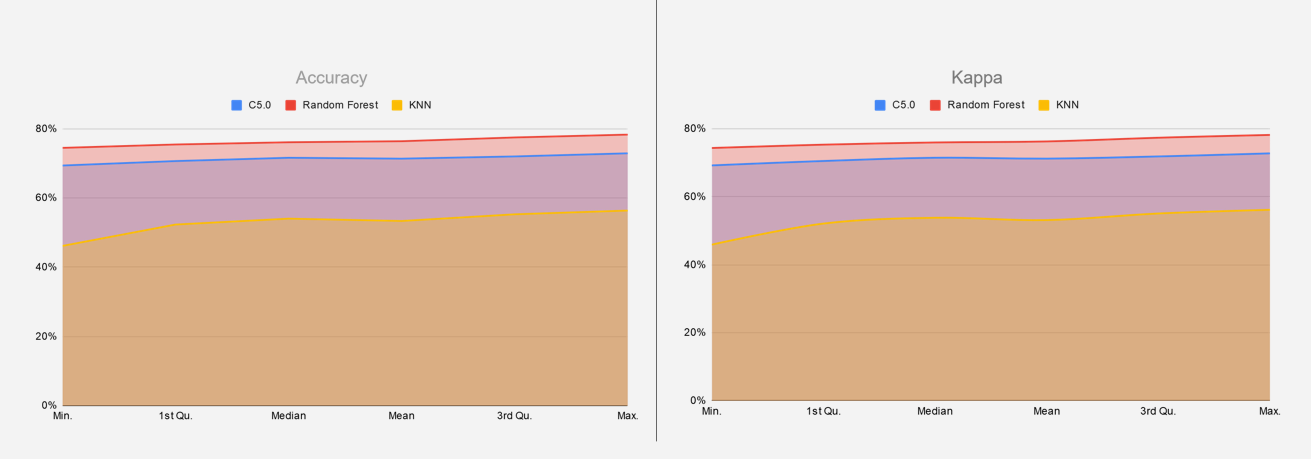

In [6]:
library("IRdisplay")
display_png(file="C:/Users/Francisco Cardoso/Documents/UT Data Analytics/Github/C3.T3/Model Comparision.png") 

As we can see on the graph below, both on Accuracy and Kappa, the best performing model is Random Forest since it achieved the better results and this would be the model recommended to be used.

However on the buisness side of things, it would be better for the company to try to implement the Beacon locationing using bluetooth since it has been proven to be more efficient than wifi locationing. 